In [ ]:
# Установка библиотеки
!pip install -q -U kaggle_environments
!pip install gymnax

# Импорты
import random
from kaggle_environments import make, evaluate
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



## **Агенты**:

In [ ]:
class RockAgent:
    """Агент, который всегда выбирает камень."""
    def __call__(self, observation, configuration):
        return 0  # Камень

class PaperAgent:
    """Агент, который всегда выбирает бумагу."""
    def __call__(self, observation, configuration):
        return 1  # Бумага

class ScissorsAgent:
    """Агент, который всегда выбирает ножницы."""
    def __call__(self, observation, configuration):
        return 2  # Ножницы

class RandomAgent:
    """Агент, выбирающий случайный ход."""
    def __call__(self, observation, configuration):
        return random.randrange(0, configuration.signs)

class CopyAgent:
    """Агент, который повторяет ход соперника."""
    def __call__(self, observation, configuration):
        if observation.step > 0:
            return observation.lastOpponentAction
        return random.randrange(0, configuration.signs)

class ReactionaryAgent:
    """Агент, который выбирает ход для победы над последним ходом соперника."""
    def __call__(self, observation, configuration):
        if observation.step > 0:
            return (observation.lastOpponentAction + 1) % configuration.signs
        return random.randrange(0, configuration.signs)

class StatisticalAgent:
    """Агент, выбирающий ход на основе статистики наиболее частых действий соперника."""
    def __init__(self):
        self.history = {}

    def __call__(self, observation, configuration):
        if observation.step == 0:
            self.history = {}
            return random.randrange(0, configuration.signs)

        opponent_move = observation.lastOpponentAction
        self.history[opponent_move] = self.history.get(opponent_move, 0) + 1
        most_common_move = max(self.history, key=self.history.get)
        return (most_common_move + 1) % configuration.signs

class MonotonousAgent:
    """Агент, который циклично меняет свои ходы (камень-бумага-ножницы)."""
    def __call__(self, observation, configuration):
        return observation.step % configuration.signs

class ReverseCycleAgent:
    """Агент, который циклично идет в обратном порядке (ножницы-бумага-камень)."""
    def __call__(self, observation, configuration):
        return (2 - observation.step % configuration.signs) % configuration.signs

class HalfCycleAgent:
    """Агент, который меняет ход каждые два шага."""
    def __init__(self):
        self.counter = 0

    def __call__(self, observation, configuration):
        self.counter += 1
        return (self.counter // 2) % configuration.signs

class AntiStatisticalAgent:
    """Агент, побеждающий наиболее частый ход соперника."""
    def __init__(self):
        self.history = {}

    def __call__(self, observation, configuration):
        if observation.step == 0:
            self.history = {}
            return random.randrange(0, configuration.signs)

        opponent_move = observation.lastOpponentAction
        self.history[opponent_move] = self.history.get(opponent_move, 0) + 1
        least_common_move = min(self.history, key=self.history.get)
        return (least_common_move + 1) % configuration.signs




## Справочник агентов:

In [ ]:
agents = {
    'rock': RockAgent(),
    'paper': PaperAgent(),
    'scissors': ScissorsAgent(),
    'random': RandomAgent(),
    'copy': CopyAgent(),
    'reactionary': ReactionaryAgent(),
    'statistical': StatisticalAgent(),
    'monotonous': MonotonousAgent(),
    'reverse_cycle': ReverseCycleAgent(),
    'half_cycle': HalfCycleAgent(),
    'anti_statistical': AntiStatisticalAgent(),
}



## Турнир:

In [ ]:
class Tournament:
    def __init__(self, agents):
        self.agents = agents
        self.results = {name: {"points": 0, "wins": 0} for name in agents}

    def __run_match(self, agent1_name, agent2_name, episodes):
        result = evaluate(
            "rps",
            [self.agents[agent1_name], self.agents[agent2_name]],
            configuration={"episodeSteps": episodes},
            debug=False
        )
        agent1_score, agent2_score = result[0]
        return agent1_score, agent2_score

    def start(self, episodes=100):
        agent_names = list(self.agents.keys())
        for i, agent1 in enumerate(agent_names):
            for agent2 in agent_names[i + 1:]:
                score1, score2 = self.__run_match(agent1, agent2, episodes)
                if score1 > score2:
                    self.results[agent1]["points"] += 2
                elif score2 > score1:
                    self.results[agent2]["points"] += 2
                else:
                    self.results[agent1]["points"] += 1
                    self.results[agent2]["points"] += 1
                self.results[agent1]["wins"] += score1
                self.results[agent2]["wins"] += score2

    def print_results(self):
        sorted_results = sorted(
            self.results.items(),
            key=lambda x: (x[1]["points"], x[1]["wins"]),
            reverse=True
        )
        df = pd.DataFrame({
            "Agent": [r[0] for r in sorted_results],
            "Points": [r[1]["points"] for r in sorted_results],
            "Wins": [r[1]["wins"] for r in sorted_results],
        })

        # Очки
        plt.figure(figsize=(12, 6))
        sns.barplot(data=df, x="Agent", y="Points", palette="viridis",  hue="Agent")
        plt.title("Результаты по очкам")
        plt.ylabel("Очки")
        plt.show()

        # Победы
        plt.figure(figsize=(12, 6))
        sns.barplot(data=df, x="Agent", y="Wins", palette="coolwarm",  hue="Agent")
        plt.title("Результаты по победам")
        plt.ylabel("Победы")
        plt.show()



## Запуск турнира:

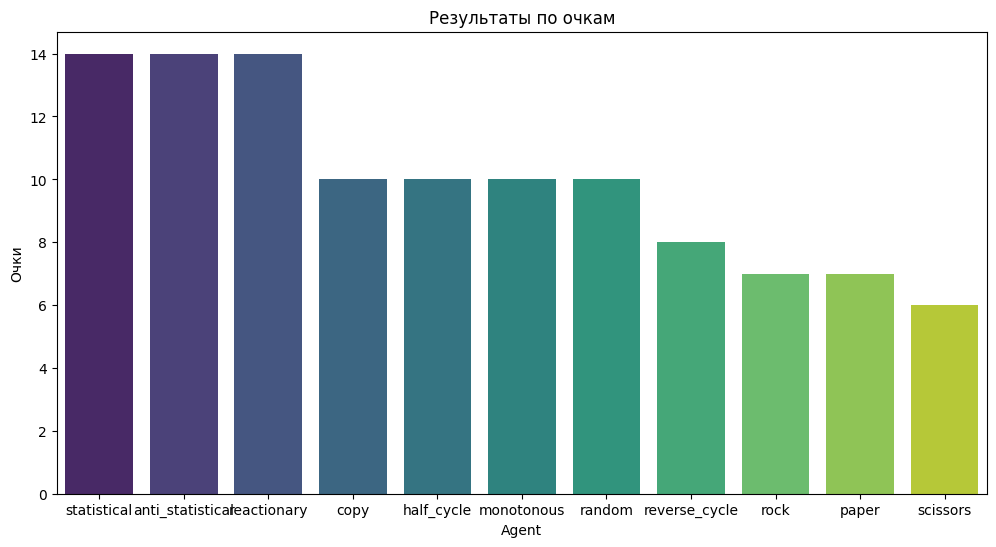

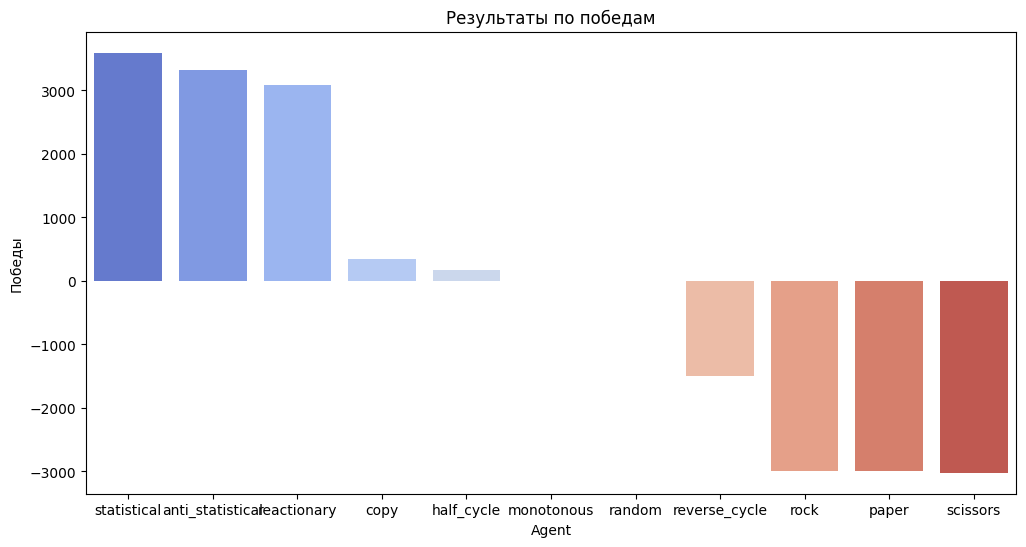

In [ ]:
tournament = Tournament(agents)
tournament.start(episodes=1000)
tournament.print_results()